In [1]:
# Imports
%matplotlib notebook
import cvxpy as cp
import numpy as np
import pylgmath
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.text import Annotation
from pylgmath.so3.operations import vec2rot
import plotting
import sim
import local_solver
from sdp_relaxation import build_SDP_problem, block_diagonal

In [2]:
# camera parameters
f_u = 100 # focal length in horizonal pixels
f_v = 100 # focal length in vertical pixels
c_u = 50 # pinhole projection in horizonal pixels
c_v = 50 # pinhold projection in vertical pixels
b = 0.2 # baseline (meters)

M = sim.make_stereo_camera_matrix(f_u, f_v, c_u, c_v, b)
R = 0 * np.eye(4) # covarience matrix for image-space noise


<IPython.core.display.Javascript object>


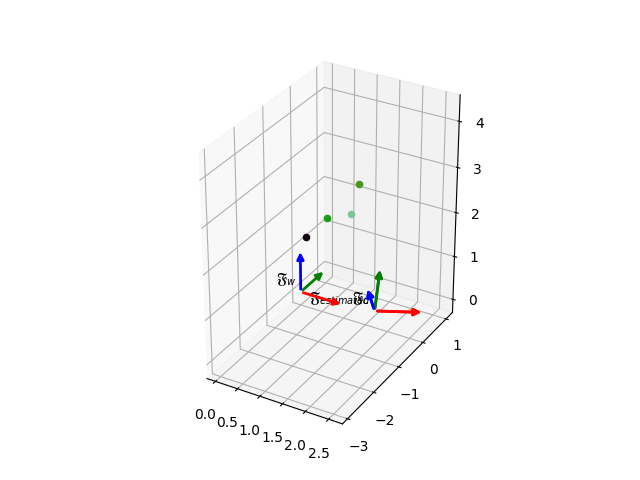

<IPython.core.display.Javascript object>


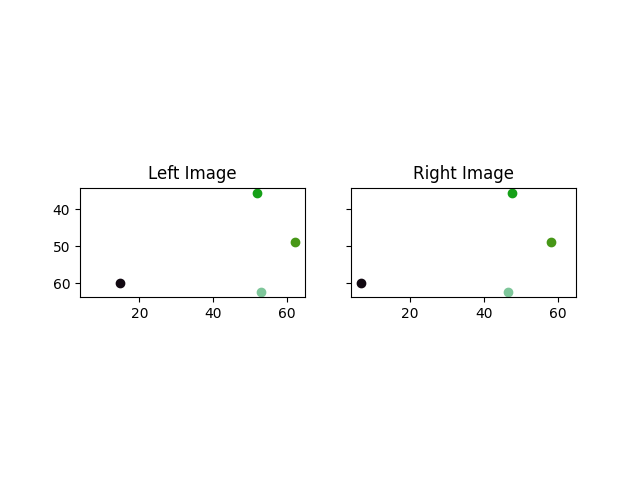

In [3]:
# make random camera pose
a = np.random.rand(3, 1)
theta = np.random.rand() * 2*np.pi
C_wc = vec2rot(theta * a/np.linalg.norm(a))
T_wc = np.eye(4)
T_wc[:3, :3] = C_wc
T_wc[:-1, -1] = [3*np.random.rand(), 3*np.random.rand(), 0]

# make sim instance w/ N points
N = 4
fig, ax, p_w, colors = sim.make_stereo_sim_instance(N, T_wc, np.array([[-1,1], [-1, 1], [2, 5]]))

# Generative camera model 
T_cw = np.linalg.inv(T_wc)
y = sim.generative_camera_model(M, T_cw, p_w)
dy = sim.generate_stereo_camera_noise(R, size = N)[:, :, None]
y = y + dy
camfig, (l_ax, r_ax) = sim.render_camera_points(y, colors)

## Stereo Localization Problem
$$\mathbf{T_{cw}} = \frac{1}{2} \text{argmin}_{\mathbf{T}} \sum_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k)^T \mathbf{W}_k (\mathbf{y}_k - \mathbf{M} \frac{1}{z_k} \mathbf{T} \mathbf{p}_k),$$
$$\mathbf{T} \in SE(3),$$
$$z_k = \mathbf{a}^T \mathbf{T} \mathbf{p}_k,$$
$$\mathbf{a}^T = \begin{bmatrix}0 & 0 & 1 & 0\end{bmatrix}.$$


## Local Solver
Let $\mathbf{x} = \mathbf{T}\mathbf{p}_k$ so
$$\mathbf{u}_k(\mathbf{x}) = \mathbf{y}_k - \frac{1}{\mathbf{a}^T\mathbf{x}} \mathbf{M} \mathbf{x}.$$

We want to find a perturbation $\mathbf{\epsilon}^*$ so we can iterativly update our estimate $\mathbf{T}$:
$$\mathbf{T} \leftarrow \exp(\mathbf{\epsilon}^{*^{\wedge}}) \mathbf{T}_{op}.$$

Linear approximation of $\mathbf{u}_k(\mathbf{T} \mathbf{p}_k)$:

$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) = \mathbf{u}_k(\exp(\mathbf{\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx \mathbf{u}_k((\mathbf{1} + {\epsilon}^{\wedge}) \mathbf{T}_{op} \mathbf{p}_k) \approx\mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) + \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k} (\mathbf{T}_{op}\mathbf{p}_k)^{\odot} \mathbf{\epsilon}$$
$$\mathbf{u}_k(\mathbf{T} \mathbf{p}_k) \approx \mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}$$

where
$$\mathbf{E}_k = (\frac{\partial \mathbf{u}_k}{\partial \mathbf{x}}|_{\mathbf{x} = \mathbf{T}_{op} \mathbf{p}_k}(\mathbf{T}_{op}\mathbf{p}_k)^{\odot})^T \in \mathbb{R}^{6 \times 4},$$
$$\mathbf{b}_k = \mathbf{u}_k(\mathbf{T}_{op}\mathbf{p}_k) \in \mathbb{R}^{4},$$
$$\frac{\partial \mathbf{u}(\mathbf{x})}{\partial \mathbf{x}} = \left(\frac{1}{\mathbf{a}^T \mathbf{x}}\right)^2 \mathbf{M} \mathbf{x} \mathbf{a}^T - \frac{1}{\mathbf{a}^T \mathbf{x}} \mathbf{M}.$$

Inserting this back into the cost function
$$\mathcal{L} = \frac{1}{2} \sum_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon})^T \mathbf{W}_k (\mathbf{b}_k + \mathbf{E}_k^T\mathbf{\epsilon}),$$

and differentiating w.r.t $\mathbf{\epsilon}$ we obtain
$$\frac{\partial \mathcal{L}}{\partial \mathbf{\epsilon}} = \frac{1}{2} \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) (\mathbf{b}_k + \mathbf{E}_k^T \mathbf{\epsilon}).$$

Setting this to zero and rearranging, we find an expression that we can solve for $\mathbf{\epsilon}^*$:
$$\left(\sum_k (\mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T) \mathbf{E}_k^T)\right) \mathbf{\epsilon^*} = - \sum_k \mathbf{E}_k (\mathbf{W}_k + \mathbf{W}_k^T)\mathbf{b}_k.$$


In [4]:
T_op = np.eye(4)
W = np.eye(4)

max_iters = 1000

T_op = local_solver.stereo_localization_gauss_newton(T_op, y, p_w, W, M)

print("Estimate:\n", T_op)
print("Ground Truth:\n", T_cw)

Loss: 1440.107647334492
Loss: 44.20598850386648
Loss: 0.020420262652866207
Loss: 3.679917595249103e-08
Loss: 1.837483444476445e-20
Loss: 2.99181568779061e-20
Estimate:
 [[ 0.94314474  0.321204    0.08547511 -1.5888641 ]
 [-0.31865634  0.80065065  0.50736247  0.43308017]
 [ 0.09453116 -0.50575343  0.85748314 -0.09786816]
 [ 0.          0.          0.          1.        ]]
Ground Truth:
 [[ 0.94314474  0.321204    0.08547511 -1.5888641 ]
 [-0.31865634  0.80065065  0.50736247  0.43308017]
 [ 0.09453116 -0.50575343  0.85748314 -0.09786816]
 [ 0.          0.          0.          1.        ]]


<IPython.core.display.Javascript object>


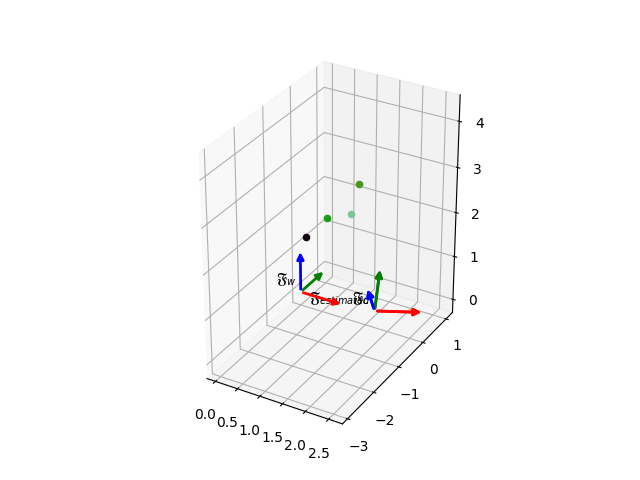

In [5]:
#visualize solution
plotting.add_coordinate_frame(np.linalg.inv(T_op), ax, "$\mathfrak{F}_{estimated}$")
fig

## SDP Relaxation Math

See `math.tex`


## SDP solver

Use MOSEK via CVXPY
https://www.cvxpy.org/examples/basic/sdp.html

In [6]:
 # Generate a random SDP.
n = 3
p = 3
np.random.seed(1)
Q = np.random.randn(n, n)
Q = Q + Q.T
A = []
b = []
for i in range(p):
    A.append(np.random.randn(n, n))
    A[-1] = A[-1] + A[-1].T
    b.append(np.random.randn())

prob, X = build_SDP_problem(Q, A, b)
prob.solve(solver=cp.MOSEK, verbose = True)

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
print(X.value)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Sep 25 12:19:31 PM: Your problem has 9 variables, 4 constraints, and 0 parameters.
(CVXPY) Sep 25 12:19:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 25 12:19:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 25 12:19:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 25 12:19:31 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Sep 25 12:19:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

## From Stereo Localization to QCQP, and QCQP to SDP

We will define:
$$\mathbf{x} = \begin{bmatrix} \mathbf{c}_1 \\ \mathbf{c}_2 \\ \mathbf{c}_3 \\ \mathbf{r} \\ \mathbf{v}_1 \\ \dots \\ \mathbf{v}_n \\ \omega_0\end{bmatrix} \in \mathbb{R}^{13 + 4n}$$

In [7]:
# Fow now use the same W for each measurement
Ws = np.zeros((N, 4, 4))
for i in range(N):
    Ws[i] = W

### Constructing The Cost Matrix

In [8]:
# Ws.shape = (N, 4, 4)
# y.shape = (N, 4, 1)
# M.shape = (4, 4)
n = 13 + 4 * N
Q = np.zeros((n, n))
(M.T @ Ws @ M).shape
Q[12:-1, 12:-1] = block_diagonal(M.T @ Ws @ M, 0)
Q[-1, -1] = np.sum(y.transpose((0, 2, 1)) @ Ws @ y)
temp = (y.transpose((0, 2, 1)) @ Ws.transpose((0, 2, 1)) @ M)
Q[-1, 12:-1] = temp.reshape(-1)
Q[12:-1, -1] = temp.transpose((0, 2, 1)).reshape(-1)

In [39]:
M.T @ Ws @ y

array([[[ 9945.44975468],
        [12491.05193595],
        [11218.25084532],
        [   63.70807502]],

       [[ 2149.46479312],
        [12016.07361559],
        [ 7082.76920436],
        [   80.67341645]],

       [[ 9940.93345831],
        [ 7093.37742708],
        [ 8517.1554427 ],
        [   41.2966996 ]],

       [[12034.5351349 ],
        [ 9750.16458713],
        [10892.34986101],
        [   40.45713638]]])

In [40]:
M.T @ y

array([[[ 9945.44975468],
        [12491.05193595],
        [11218.25084532],
        [   63.70807502]],

       [[ 2149.46479312],
        [12016.07361559],
        [ 7082.76920436],
        [   80.67341645]],

       [[ 9940.93345831],
        [ 7093.37742708],
        [ 8517.1554427 ],
        [   41.2966996 ]],

       [[12034.5351349 ],
        [ 9750.16458713],
        [10892.34986101],
        [   40.45713638]]])

In [41]:
Ws

array([[[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]])

In [27]:
M.T @ M

array([[20000.,     0., 10000.,     0.],
       [    0., 20000., 10000.,     0.],
       [10000., 10000., 10000.,     0.],
       [    0.,     0.,     0.,   200.]])

### Constructing the rotation constraint matricies

In [9]:
As = []
bs = [1, 1, 1, 0, 0, 0]

A1 = np.zeros((n, n))
A1[0:3, 0:3] = np.eye(3)
As.append(A1)

A2 = np.zeros((n, n))
A2[3:6, 3:6] = np.eye(3)
As.append(A2)

A3 = np.zeros((n, n))
A3[6:9, 6:9] = np.eye(3)
As.append(A3)

A4 = np.zeros((n, n))
A4[0:3, 3:6] = np.eye(3)
A4 = 0.5 * (A4 + A4.T)
As.append(A4)

A5 = np.zeros((n, n))
A5[0:3, 6:9] = np.eye(3)
A5 = 0.5 * (A5 + A5.T)
As.append(A5)

A6 = np.zeros((n, n))
A6[3:6, 6:9] = np.eye(3)
A6 = 0.5 * (A6 + A6.T)
As.append(A6)

### Homogenization Variable Constraint

In [10]:
A7 = np.zeros((n, n))
A7[-1, -1] = 1
As.append(A7)
bs.append(1)

### Sensor Constraint Matrices

In [11]:
# p_w.shape = (N, 4, 1)
#TODO: batch this operation (so it is fast when dealing with lots of points)

for k in range(N):
    A1 = np.zeros((n, n))
    A1[-1, [0, 3, 6, 9]] = p_w[k].reshape(-1)
    A1[[2, 5, 8, 11], 12 + k*4] = -p_w[k].reshape(-1)
    A1 = 0.5 * (A1 + A1.T)
    As.append(A1)
    bs.append(0)
    
    A2 = np.zeros((n, n))
    A2[-1, [1, 4, 7, 10]] = p_w[k].reshape(-1)
    A2[[2, 5, 8, 11], 12 + k*4 + 1] = -p_w[k].reshape(-1)
    A2 = 0.5 * (A2 + A2.T)
    As.append(A2)
    bs.append(0)
    
    
    A3 = np.zeros((n, n))
    A3[-1, [2, 5, 8, 11]] = p_w[k].reshape(-1)
    A3[[2, 5, 8, 11], 12 + k*4 + 2] = -p_w[k].reshape(-1)
    A3 = 0.5 * (A3 + A3.T)
    As.append(A3)
    bs.append(0)
    
    A4 = np.zeros((n, n))
    A4[[2, 5, 8, 11], 12 + k*4 + 3] = p_w[k].reshape(-1)
    A4 = 0.5 * (A4 + A4.T)
    As.append(A4)
    bs.append(1)

    A5 = np.zeros((n, n))
    A5[12 + k*4 +2, 12 + k*4 +2] = 1
    A5 = 0.5 * (A5 + A5.T)
    As.append(A5)
    bs.append(1)


In [12]:
prob, X = build_SDP_problem(Q, As, bs)
prob.solve(solver=cp.MOSEK, verbose = True)

# Print result.
print("The optimal value is", prob.value)
print("A solution X is")
X = X.value
print(X)
print(X.shape)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Sep 25 12:19:31 PM: Your problem has 841 variables, 28 constraints, and 0 parameters.
(CVXPY) Sep 25 12:19:31 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 25 12:19:31 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 25 12:19:31 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 25 12:19:31 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Sep 25 12:19:31 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing

(CVXPY) Sep 25 12:19:32 PM: Interior-point solution summary
(CVXPY) Sep 25 12:19:32 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Sep 25 12:19:32 PM:   Solution status : OPTIMAL
(CVXPY) Sep 25 12:19:32 PM:   Primal.  obj: 1.3496098912e-03    nrm: 4e+04    Viol.  con: 2e-03    var: 0e+00    barvar: 0e+00  
(CVXPY) Sep 25 12:19:32 PM:   Dual.    obj: 1.3489511402e-03    nrm: 7e+04    Viol.  con: 0e+00    var: 6e-12    barvar: 2e-11  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Sep 25 12:19:32 PM: Problem status: optimal
(CVXPY) Sep 25 12:19:32 PM: Optimal value: 1.349e-03
(CVXPY) Sep 25 12:19:32 PM: Compilation took 2.290e-01 seconds
(CVXPY) Sep 25 12:19:32 PM: Solver (including time spent in interface) took 2.341e-01 seconds
The optimal value is 0.0013489511301973296
A soluti